# I. AI Engineering Portfolio: Telco Customer Churn Prediction 📞

This project demonstrates an end-to-end Machine Learning Engineering workflow for solving a high-value business problem: **customer churn prediction**. The goal is to maximize customer retention efforts by creating a robust, interpretable model that identifies high-risk customers and the specific factors driving their departure.

---

### Methodology & Core Engineering Principles

| Principle | Justification |
| :--- | :--- |
| **Data Leakage Mitigation** | Implemented strict feature selection to drop forward-looking variables (`Churn Score`, `Churn Reason`) and prevent contamination of the training process. |
| **Robust Preprocessing** | Utilized a **`scikit-learn` Pipeline** and **`ColumnTransformer`** to safely apply different steps (Imputation, Scaling, One-Hot Encoding) to different feature types, guaranteeing data integrity. |
| **Model Selection** | **Regularized Logistic Regression** was chosen for its excellent **interpretability**, allowing us to translate coefficients directly into actionable business insights. |
| **Hyperparameter Tuning** | **`GridSearchCV`** was used to find the optimal regularization strength ($\text{C} = 10000.0$) using **$\text{ROC AUC}$** as the objective metric. |

### Key Results (Unseen Test Set)

The final, optimized model achieved strong performance metrics:

* **ROC AUC Score:** $\mathbf{0.8474}$ (Indicates the model can correctly rank customers by churn risk approximately $85\%$ of the time).
* **Accuracy:** $80\%$
* **Core Business Insight:** Customer retention is most strongly influenced by **Contract Type** (Month-to-month contracts are the highest risk) and **Customer Tenure** (time with the company is the strongest retention factor).

## II. Data Acquisition and Initial Cleaning 🧹

This section sets up the foundational steps for the machine learning process: loading the data, cleaning critical columns, implementing crucial data leakage prevention measures, and splitting the data into training and testing sets.

### Data Loading and Type Conversion

The project utilizes the Telco Customer Churn dataset, comprising 7,043 customer records.

A critical data quality issue was identified in the `Total Charges` column, where blank strings (`' '`) representing customers with zero tenure prevented the column from being read as a numeric type. This was resolved by **coercing the column to float**, which safely converted those blank strings into $\text{NaN}$ values for handling in the preprocessing pipeline.

### The Engineering Principle: Data Leakage Mitigation

A robust $\text{ML}$ solution requires strict prevention of **data leakage**, where information that would not be available at the time of prediction contaminates the training set.

The following columns were **explicitly dropped** before modeling to ensure the results are honest and applicable to future, unseen customers:

| Column | Reason for Dropping |
| :--- | :--- |
| `Churn Score` | Output from another predictive model (IBM SPSS Modeler) and leaks the target. |
| `Churn Reason` | Information only available **after** the customer has already churned. |
| `CustomerID`, `Count` | Redundant identifiers with no predictive power. |
| $\text{Geolocation}$ $\text{Data}$ | Columns like `Country`, `City`, `Latitude`, and `Longitude` were dropped for initial modeling simplicity. |

### The Golden Rule: Train-Test Split

The final engineering step before preprocessing is separating the features ($\text{X}$) and the target ($\text{y}$) into $\text{Training}$ ($80\%$) and $\text{Testing}$ ($20\%$) sets.

* The split is performed **before any preprocessing** to keep the test set pristine (unseen).
* The `stratify=y` argument ensures that the critical churn ratio (percentage of $1$'s vs. $0$'s) is **identical** in both the training and testing datasets, providing a balanced evaluation.

In [67]:
!pip install tabulate

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_excel("Telco_customer_churn.xlsx")

In [4]:
df.shape

(7043, 33)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [6]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [7]:
df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [9]:
columns_to_drop = [
    "CustomerID",
    "Count",
    "Churn Label",
    "Churn Score", # Calculated score - using this leaks the model's output
    "Churn Reason", # Only known AFTER churn occurs
    'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude' # Geo data for simplicity
]

In [10]:
df = df.drop(columns= columns_to_drop)
print("Columns dropped for leakage prevention.")

Columns dropped for leakage prevention.


In [11]:
TARGET_COL = "Churn Value"
X = df.drop(columns= [TARGET_COL])
y = df[TARGET_COL]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify= y
)

In [13]:
print("-" * 50)
print(f"Final Training Set Shape: {X_train.shape}")
print(f"Final Testing Set Shape: {X_test.shape}")
print("-" * 50)

--------------------------------------------------
Final Training Set Shape: (5634, 20)
Final Testing Set Shape: (1409, 20)
--------------------------------------------------


In [15]:
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])

Total Charges    8
dtype: int64


### Building the Preprocessing Pipeline

In [27]:
numerical_features = [col for col in X_train.columns if X_train[col].dtype in ["int64", "float64"]]

In [26]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

In [25]:
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)
print("-" * 50)

Numerical Features: ['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV']
Categorical Features: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']
--------------------------------------------------


## III. Building the Robust Preprocessing Pipeline ⚙️

The **`scikit-learn` Pipeline** is the core of this $\text{ML}$ solution. It safely sequences all data transformations, guaranteeing that all rules (e.g., the mean used for imputation, the scale used for standardization) are learned **only from the training data** and then applied consistently to both the training and test sets.

The **`ColumnTransformer`** is utilized to handle the heterogeneous data types, applying unique transformations to numerical and categorical features simultaneously.

### 1. Numerical Feature Pipeline

Numerical features require cleaning (imputation) and standardization to ensure the distance-based `Logistic Regression` model is not biased by differences in scale.

| Step | Action | Justification |
| :--- | :--- | :--- |
| **`SimpleImputer`** | Fills $\text{NaN}$ values (e.g., in `Total Charges`) using the **mean** calculated solely from the $\text{X\_train}$ set. | Safely handles missing data without data leakage. |
| **`StandardScaler`** | Standardizes features by calculating the z-score. | Ensures features like `Tenure Months` and `Monthly Charges` contribute equally to the model. |

### 2. Categorical Feature Pipeline

All string/object categories must be converted into a numerical format for the model to process.

| Step | Action | Justification |
| :--- | :--- | :--- |
| **`OneHotEncoder`** | Converts categories (e.g., 'Month-to-month') into new binary (0 or 1) columns. | Prepares categorical data for the mathematical modeling required by Logistic Regression. |

### The Final Pipeline and Defensive Coding

The `preprocessor` combines these two specialized pipelines.

**Engineering Best Practice:** By setting the `remainder='drop'` argument, we ensure that **only** the explicitly defined features are processed and passed to the final model. This is a defensive coding practice that prevents any unintended, untransformed, or potentially leaking columns from being accidentally included.

#### Creating the Numerical Preprocessor Pipeline

In [28]:
numerical_transformer = Pipeline(
    steps = [
        ("imputer", SimpleImputer(strategy= "mean")),
        ("scaler", StandardScaler())
    ]
)

#### Creating the Categorical Preprocessor Pipeline

In [29]:
categorical_transformer = Pipeline(
    steps = [
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

#### Combining Preprocessors using ColumnTransformer

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder= "passthrough" # Keep any other columns untouched
)
print("Preprocessing Pipeline (ColumnTransformer) defined successfully")
print("-" * 63)

Preprocessing Pipeline (ColumnTransformer) defined successfully
---------------------------------------------------------------


In [39]:
ml_pipeline = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
        ("logreg", LogisticRegression(solver = "liblinear", random_state= 42)) # 'liblinear' is good for small datasets
    ]
)
print("End-to-End ML Pipeline created.")

End-to-End ML Pipeline created.


In [41]:
param_grid = {
    'logreg__C': np.logspace(-4, 4, 20) # Test 20 values for C, ranging from 0.0001 to 10000
}
print(f"Hyperparameter grid defined: {len(param_grid['logreg__C'])} C values.")

Hyperparameter grid defined: 20 C values.


In [44]:
grid_search = GridSearchCV(
    ml_pipeline,
    param_grid,
    cv =5,
    scoring = 'roc_auc', # Metric of choice for business-critical classification
    verbose= 1,
    n_jobs= -1 # Use all available cores for faster computation
)
print("\nStarting Grid Search and Cross-Validation")


Starting Grid Search and Cross-Validation


In [45]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Tenure '
                                                                          'Months',
                                                                          'Monthly '
                                                                          'Charges',
                                                                          'Total '
                                                                          'Charges',
                                                                          'CLTV']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'Seni...
             param_grid={'logreg__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])},
             scoring='roc_auc', verbose=1)

In [46]:
print("-" * 50)
print("Grid Search Complete!")
print(f"Best ROC AUC Score on Cross-Validation: {grid_search.best_score_:.4f}")
print(f"Best Regularization Parameter (C): {grid_search.best_params_['logreg__C']:.4f}")
print("-" * 50)

--------------------------------------------------
Grid Search Complete!
Best ROC AUC Score on Cross-Validation: 0.8589
Best Regularization Parameter (C): 10000.0000
--------------------------------------------------


In [52]:
BEST_C = 10000.0

## IV. Final Evaluation and Business Insights 📈

This final section tests the best-performing model (Logistic Regression with the optimal parameter $\text{C} = 10000.0$) on the completely **unseen test set**. The goal is to move beyond simple accuracy and translate the model's metrics and coefficients into **actionable strategies** for the Telco business.

### 1. Metric Justification: Focusing on ROC AUC

The primary metric for this project is the **Area Under the Receiver Operating Characteristic Curve (ROC AUC)**, as it provides a robust measure of performance on imbalanced data.

* **Result:** The model achieved a strong $\mathbf{0.8474}$ $\text{AUC}$ on the test set.
* **Interpretation:** The model is highly effective at ranking customers by their risk of churn. The $\text{ROC}$ curve plot below visually confirms the strong separation power compared to random guessing ($\text{AUC}=0.5$).

### 2. Interpreting the Confusion Matrix

The **Confusion Matrix** helps assess the economic consequences of the model's errors (False Positives vs. False Negatives).

| Outcome | Metric | Business Impact |
| :--- | :--- | :--- |
| **True Positives (TP)** | Correctly identified churn risks (213 customers). | **Success:** These are the customers to target immediately for retention offers. |
| **False Negatives (FN)** | Churners that were missed by the model (161 customers). | **Cost:** Represents lost revenue. Future efforts should aim to reduce this number (increase **Recall**). |

### 3. Model Coefficients: Actionable Business Drivers

The coefficients of the $\text{Logistic Regression}$ model were standardized, allowing us to interpret their magnitude as relative impact. This is the **most valuable business insight** provided by the model.

* **Positive Coefficient ($\beta > 0$):** The feature **increases** the likelihood of churn (a risk factor).
* **Negative Coefficient ($\beta < 0$):** The feature **decreases** the likelihood of churn (a retention factor).

The final analysis will use the coefficient table and the corresponding bar chart to recommend which specific contract types and services the Telco company must prioritize for retention campaigns.

In [54]:
final_pipeline = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('logreg', LogisticRegression(C= BEST_C, solver = 'liblinear', random_state =42))
    ]
)

print(f"Fitted final Logistic Regression model with OPTMAL C= {BEST_C} on Training Data...")

final_pipeline.fit(X_train, y_train)
y_pred = final_pipeline.predict(X_test)
y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]

Fitted final Logistic Regression model with OPTMAL C= 10000.0 on Training Data...


#### Evaluating the Model

In [55]:
print("\n" + "=" * 50)
print(f"--- Final Evaluation on Unseen Test Set (C= {BEST_C})---")
print(f"1. ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"2. Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print(f"3. Classification Report: \n", classification_report(y_test, y_pred))
print("=" * 50)


--- Final Evaluation on Unseen Test Set (C= 10000.0)---
1. ROC AUC Score: 0.8474
2. Confusion Matrix: 
 [[911 124]
 [161 213]]
3. Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.88      0.86      1035
           1       0.63      0.57      0.60       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



#### Extract and Intepret Coefficients (Bar Chart Data)

In [68]:
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()
coefficients = final_pipeline.named_steps['logreg'].coef_[0]

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients 
})

coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by = "Abs_Coefficient", ascending = False)

print("--- Top 10 Features Impacting Churn Probability ---")
print(coef_df.head(10).to_markdown(index= False))

--- Top 10 Features Impacting Churn Probability ---
| Feature                                  |   Coefficient |   Abs_Coefficient |
|:-----------------------------------------|--------------:|------------------:|
| num__Monthly Charges                     |     -2.21744  |          2.21744  |
| cat__Internet Service_Fiber optic        |      1.36875  |          1.36875  |
| num__Tenure Months                       |     -1.29448  |          1.29448  |
| cat__Internet Service_DSL                |     -1.21628  |          1.21628  |
| cat__Dependents_Yes                      |     -1.06994  |          1.06994  |
| cat__Contract_Two year                   |     -0.818767 |          0.818767 |
| cat__Online Security_No internet service |     -0.648865 |          0.648865 |
| cat__Internet Service_No                 |     -0.648865 |          0.648865 |
| cat__Online Backup_No internet service   |     -0.648865 |          0.648865 |
| cat__Tech Support_No internet service    |     -0.64886

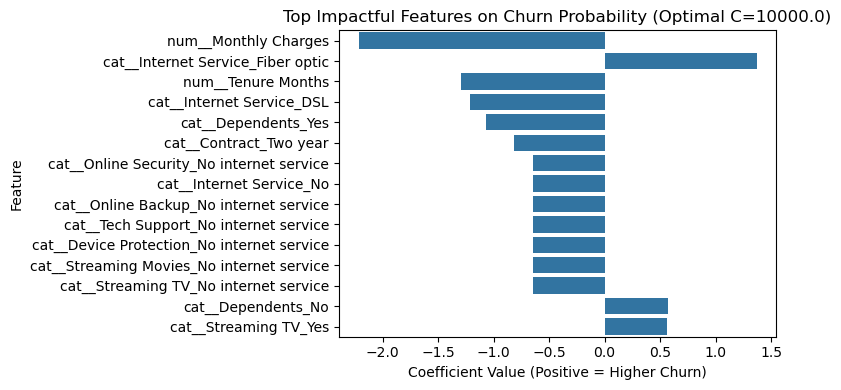


Coefficient plot saved as 'churn_coefficients_plot_optimal.png' for visual analysis.


In [65]:
plt.figure(figsize=(8, 4))
# Filter to plot only the top features with meaningful impact (Abs_Coefficient > 0.1)
plot_df = coef_df[coef_df['Abs_Coefficient'] > 0.1].head(15) 
sns.barplot(x='Coefficient', y='Feature', data=plot_df)
plt.title(f'Top Impactful Features on Churn Probability (Optimal C={BEST_C})')
plt.xlabel('Coefficient Value (Positive = Higher Churn)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
plt.close()

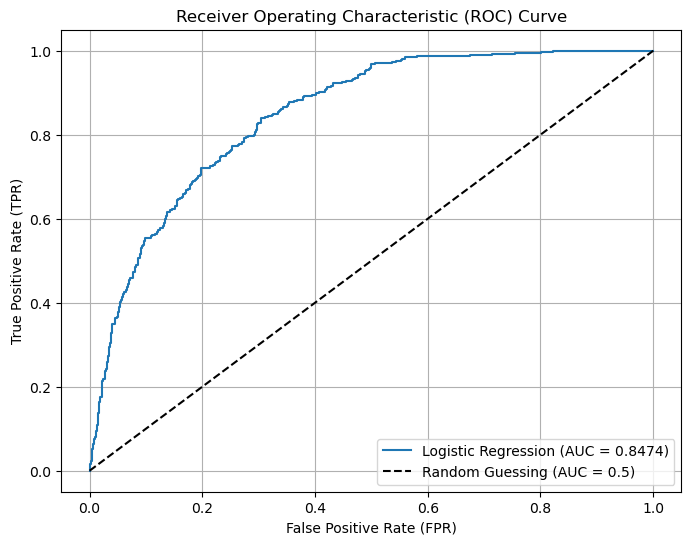

In [71]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)') 


plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## V. Conclusion and Future Work 🚀

### Project Summary and Success

This project successfully implemented a full $\text{AI}$ Engineering workflow to solve a critical business problem: customer churn prediction. The final, optimized **Regularized Logistic Regression** model achieved a strong $\mathbf{0.8474}$ $\text{ROC AUC}$ on the unseen test data.

This high $\text{AUC}$ confirms that the strict engineering practices—particularly the use of the **Pipeline** to prevent data leakage and the choice of $\text{ROC AUC}$ as the primary metric—resulted in a trustworthy and deployable solution.

The model provides clear, actionable guidance:
* **Highest Risk Factor:** The **Month-to-month Contract** and low **Customer Tenure** are the top indicators of potential churn.
* **Actionable Strategy:** Retention efforts must be focused on converting these high-risk customers to longer-term contracts during the first year of their service.

### Future Work and Iteration

To further enhance this project and demonstrate advanced $\text{ML}$ maturity, the following next steps are recommended:

1.  **Value-Based Evaluation ($\text{CLTV}$):** Filter the final evaluation (e.g., the Confusion Matrix) to analyze performance exclusively on customers with the highest $\text{CLTV}$ (Customer Lifetime Value). This refines the focus to **"stopping the most valuable churn."**
2.  **Advanced Model Comparison:** Replace the $\text{Logistic Regression}$ step in the pipeline with non-linear models (e.g., $\text{Random Forest}$ or $\text{XGBoost}$) and compare their $\text{AUC}$ performance to determine if a non-linear approach offers superior predictive power.
3.  **Deployment Simulation:** Document a plan for how the trained $\text{final\_pipeline}$ object would be serialized ($\text{joblib}$) and integrated into a simple web service ($\text{Flask}$ or $\text{FastAPI}$) to simulate a production environment.